<a href="https://colab.research.google.com/github/graccelinn/Unstructured_Assignment_3/blob/main/Task_E_and_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
import statsmodels.api as sm

In [3]:
# Load in the data
url = "https://raw.githubusercontent.com/graccelinn/Unstructured_Assignment_3/main/campaigns_file.csv"
campaigns_file = pd.read_csv(url)
campaigns_file.head()

,title,description,amount_usd,goal_usd,duration_days,cover_image,url,image_labels,binary
0,2nd Annual Massage fundraiser for Homeward Ani...,Last years fundraiser for the Homeward Animal ...,1000.00,1000.0,43.0,https://images.gofundme.com/3hguyHJimIvbn6Cr6m...,https://www.gofundme.com/f/2nd-annual-massage-...,"Dog, Vertebrate, Carnivores, Snout, Working an...",0
1,GCFA: Fundraiser for High Shelter Census and H...,CALLING ALL ANIMAL LOVERS & SHELTER SUPPORTERS...,1495.00,5000.0,78.0,https://images.gofundme.com/bSnOcdg33RMZfoYWlt...,https://www.gofundme.com/f/help-gcfa-ferrets-b...,"Snout, Advertising, Photo caption, Rodent, Fur...",1
2,Help for Balkanabat Dog Haven,"My name is Dmitry, I live in Balkanabat, Turkm...",174.00,13000.0,7.0,https://images.gofundme.com/ca0ib-jbVfhNWaslYL...,https://www.gofundme.com/f/help-for-balkanabat...,"Dog, Carnivores, Street dog, Snout, Working an...",0
3,Support Daniel's Eagle Scout Project for the A...,"Hi, my name is Daniel Watrous. I am a Life Sco...",1500.00,1500.0,531.0,https://images.gofundme.com/H-EKZ8nalH3eeYBBBK...,https://www.gofundme.com/f/support-daniels-eag...,"Facial expression, Smile, Scout, Carnivores, F...",1
4,Marathon Madness for a Animal Shelter & Dement...,"Hey, I’m Emma ☺️, and I’ve made the (probably ...",1031.25,625.0,378.0,https://images.gofundme.com/26ICpSFlt_932tMOW7...,https://www.gofundme.com/f/marathon-madness-fo...,"Body of water, Coast, Sea, Coastal and oceanic...",0


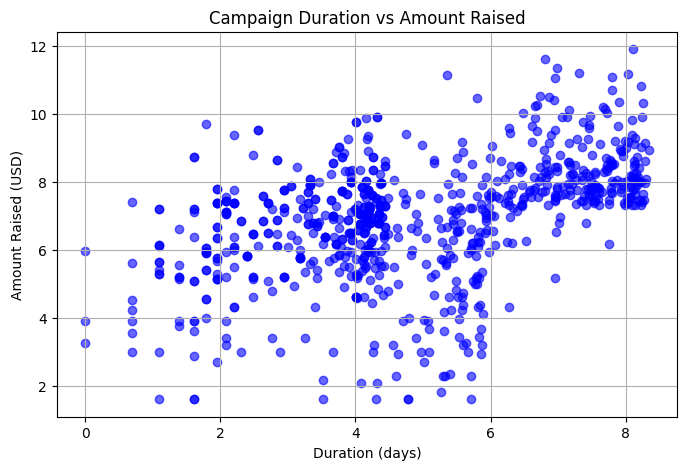

In [4]:
# this code block isn't needed in the final submission, just something I was playing around with

plt.figure(figsize=(8, 5))
plt.scatter(np.log(campaigns_file["duration_days"]), np.log(campaigns_file["amount_usd"]), alpha=0.6, color="blue")
plt.xlabel("Duration (days)")
plt.ylabel("Amount Raised (USD)")
plt.title("Campaign Duration vs Amount Raised")
plt.grid(True)
plt.show()


before topic modeling, create 1000x1000 matrix of words from images and calculate cosine similarty for each. then select 200 images with the lowest similarity in order to have images that are distinct and to get clearer separation from topic modeling

In [5]:
# Step 1: Build vocabulary and create word count matrix
vectorizer = CountVectorizer(token_pattern=r'[^,;|\n]+')
X = vectorizer.fit_transform(campaigns_file['image_labels'].str.lower())

# Step 2: Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(X)

# Step 3: Calculate average similarity for each image (excluding self-similarity)
np.fill_diagonal(similarity_matrix, 0)
avg_similarity = similarity_matrix.mean(axis=1)

# Step 4: Select 200 images with lowest similarity
distinct_indices = np.argsort(avg_similarity)[:200]
distinct_images = campaigns_file.iloc[distinct_indices].copy()
distinct_images['avg_similarity'] = avg_similarity[distinct_indices]

print(f"Selected {len(distinct_images)} most distinct images")
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
print(f"\nTop 10 most distinct:")
print(distinct_images[['image_labels', 'avg_similarity']].head(10))

Selected 200 most distinct images
Vocabulary size: 944

Top 10 most distinct:
                                          image_labels  avg_similarity
852                                           Graphics        0.000000
206                                         TEXT: ices        0.000000
126                                             Silver        0.000000
109  TEXT: MUTT STRUTT\nIn Memory of\nANN LEWIS\nJo...        0.000000
539                          Night, Darkness, Midnight        0.000000
946                                  Building material        0.000000
596                                            Baggage        0.000000
170                      TEXT: ARF\nHEAVEN FOR ANIMALS        0.000000
473  High-rise building, Metropolis, Tower, Condomi...        0.000143
889                 Palm trees, California palm, Waste        0.000194


In [6]:
# select whether you want to use all 1000 images (campaigns_file) or the 200 most unique images (distinct_images):
df = campaigns_file.copy()

In [7]:
# Concatenate description and image_labels
df["text_combined"] = df["description"].fillna("") + " " + df["image_labels"].fillna("")

# Create Bag-of-Words
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df["image_labels"].fillna(""))

# Fit LDA with n topics
n = 5
lda = LatentDirichletAllocation(n_components=n, random_state=42)
lda.fit(X)

# Get feature names (words)
words = vectorizer.get_feature_names_out()

# 1️⃣ Topic-word probabilities (reshape so each row = word)
topic_word_probs = lda.components_.T  # transpose so words are rows
topic_word_probs = topic_word_probs / topic_word_probs.sum(axis=0)  # normalize to probabilities

lda_topic_word_probabilities = pd.DataFrame(topic_word_probs, index=words, columns=[f"Topic_{i}" for i in range(1, n+1)])
lda_topic_word_probabilities.index.name = "word"
print("Topic-word probabilities (one word per row):")
print(lda_topic_word_probabilities.head())

# 2️⃣ Document-topic percentages with index and title
doc_topic_df = pd.DataFrame(lda.transform(X), columns=[f"Topic_{i}" for i in range(1, n+1)])
doc_topic_df.insert(0, "duration_days", df["duration_days"])    # add duration days as a column
doc_topic_df.insert(0, "amount_usd", df["amount_usd"])          # add amount donated as a column
doc_topic_df.insert(0, "title", df["title"])                    # add title as a column
doc_topic_df.insert(0, "index", df.index)                       # add original index as a column

lda_document_topic_percentages = doc_topic_df
print("\nDocument-topic percentages with index and title:")
print(lda_document_topic_percentages.head())

# Optional: save to CSV
lda_topic_word_probabilities.to_csv("lda_topic_word_probabilities.csv")
lda_document_topic_percentages.to_csv("lda_document_topic_percentages.csv", index=False)


Topic-word probabilities (one word per row):
                  Topic_1   Topic_2   Topic_3   Topic_4   Topic_5
word                                                             
3d               0.001136  0.000117  0.000127  0.000032  0.000117
academic         0.001136  0.000117  0.000127  0.000032  0.000117
accipitridae     0.000189  0.000698  0.000130  0.000032  0.000118
accipitriformes  0.000189  0.000698  0.000130  0.000032  0.000118
active           0.003030  0.000117  0.000127  0.000032  0.000117

Document-topic percentages with index and title:
   index                                              title  amount_usd  \
0      0  2nd Annual Massage fundraiser for Homeward Ani...     1000.00   
1      1  GCFA: Fundraiser for High Shelter Census and H...     1495.00   
2      2                      Help for Balkanabat Dog Haven      174.00   
3      3  Support Daniel's Eagle Scout Project for the A...     1500.00   
4      4  Marathon Madness for a Animal Shelter & Dement...     1031

In [8]:
# Display top 10 words for each topic as a list
for topic in lda_topic_word_probabilities.columns:
    top_words = lda_topic_word_probabilities.sort_values(by=topic, ascending=False).head(10)
    print(f"Top 10 words for {topic}:")
    print(list(top_words.index))
    print("\n")

Top 10 words for Topic_1:
['smile', 'care', 'happiness', 'medical', 'eyewear', 'child', 'scout', 'vision', 'leisure', 'people']


Top 10 words for Topic_2:
['cat', 'felidae', 'felinae', 'whiskers', 'carnivores', 'fur', 'snout', 'domestic', 'haired', 'short']


Top 10 words for Topic_3:
['smile', 'happiness', 'facial', 'expression', 'graphics', 'design', 'tooth', 'graphic', 'hair', 'fun']


Top 10 words for Topic_4:
['dog', 'animal', 'carnivores', 'canidae', 'snout', 'working', 'vertebrate', 'supply', 'fur', 'collar']


Top 10 words for Topic_5:
['supply', 'dog', 'pet', 'kennel', 'shelter', 'animal', 'carnivores', 'canidae', 'cage', 'mesh']




In [9]:
# Optional: if using 5 topics, combine topic 1 and topic 3 for happiness:
lda_document_topic_percentages['Topic_1'] = lda_document_topic_percentages['Topic_1'] + lda_document_topic_percentages['Topic_3']
lda_document_topic_percentages.drop(columns=['Topic_3'], inplace=True)
n -=1

# Identify topic columns
topic_cols = lda_document_topic_percentages.columns[-n:]

# Compute quartiles
q_high = lda_document_topic_percentages["amount_usd"].quantile(0.75)
q_low = lda_document_topic_percentages["amount_usd"].quantile(0.25)

# Select top and bottom quartiles
df_high = lda_document_topic_percentages[lda_document_topic_percentages["amount_usd"] >= q_high]
df_low = lda_document_topic_percentages[lda_document_topic_percentages["amount_usd"] <= q_low]

# Compute average topic weights
high_avg = df_high[topic_cols].mean()
low_avg = df_low[topic_cols].mean()

# Create comparison table
comparison = pd.DataFrame({
    "High Quartile Avg": high_avg,
    "Low Quartile Avg": low_avg,
    "Difference (High - Low)": high_avg - low_avg
})

# Show table
print(comparison)


         High Quartile Avg  Low Quartile Avg  Difference (High - Low)
Topic_1           0.260882          0.218363                 0.042519
Topic_2           0.112739          0.154850                -0.042112
Topic_4           0.461224          0.491171                -0.029947
Topic_5           0.165156          0.135615                 0.029540


In [39]:
# View example images which have high amount raised and are also high in a particular topic
topic = "Topic_4"

# marge topic modeling with original features
df = pd.merge(campaigns_file, lda_document_topic_percentages, on = ["title", "amount_usd", "duration_days"]).drop_duplicates(subset = ['url'])
df.sort_values(by=topic, ascending=False, inplace=True)

# Calculate the 75th percentile (top quartile threshold) for both columns
amount_q75 = df['amount_usd'].quantile(0.75)
topic_q75 = df[topic].quantile(0.75)

# Filter to keep only rows in the top quartile for both
df_filtered = df[(df['amount_usd'] >= amount_q75) & (df[topic] >= topic_q75)]

import requests
from IPython.display import HTML, display

for i in range(10):
  url = df_filtered['url'].iloc[i]
  print(f"URL: {url}")

URL: https://www.gofundme.com/f/2neeqvg?qid=aba8518be6e50e5e90adc75a115b7193
URL: https://www.gofundme.com/f/help-king-walk-again-e3kzs?qid=05451dc5b43081aeb17b15534d4b4c3f
URL: https://www.gofundme.com/f/vaso-animal-shelter-greece-vets-food-medicine?qid=8dbb1d69a9c640018f0c886ef3ef1c83
URL: https://www.gofundme.com/f/Saving-Macedonian-Strays?qid=24b7fcc1b75d583a5827127644c1df23
URL: https://www.gofundme.com/f/help-animal-shelter-workers-fleeing-gaza?qid=1270d883a0d75e895e6b31bc1bc4cb8b
URL: https://www.gofundme.com/f/andros-animal-shelter-greece?qid=8dbb1d69a9c640018f0c886ef3ef1c83
URL: https://www.gofundme.com/f/emergency-elt-animal-shelter-relocation?qid=aba8518be6e50e5e90adc75a115b7193
URL: https://www.gofundme.com/f/animal-shelter-agonda-asa-needs-a-new-van?qid=1270d883a0d75e895e6b31bc1bc4cb8b
URL: https://www.gofundme.com/f/two-women-run-animal-shelters-in-mexico-city?qid=7043aa8d406d10bc6b86365fab710493
URL: https://www.gofundme.com/f/moes-animal-shelter-needs-your-help?qid=24b7

# Task F

What advice would you give to the organization if it wants to increase the $ raised based on your findings?